##  Assessment 3
##  WebCrawler and NLP System

## Task2
### Data Aquisition and Store

This programme consumes data from two wine websites, 'nicks.com.au' and 'vivino.com'. From the nicks.com.au site, 10,080 wine items are scraped with their expert reviews/descriptions. From 'vivino.com', the non-expert wine reviews are scrapped using the wine list from 'nicks.com.au'. In addition to the community reviews, their averaged wine rating is also acquired. These two sites were used due to there being a large inventory of wines and reviews. Wines between $15 and $40 are selected, firstly to reduce scrapping time and secondly, this price bracket is assumed a typical price range for most people. In principle, thousands of wines can be scraped.

The data extracted from nicks.com.au site is wine vintage (year), wine name, price, and description/review. The price is per bottle and the description/review are expert reviews describing the wine using expert wine words, for example wine 2019 30 Mile Shiraz, ‘*Fresh and inky the nose tosses up a mix of crushed berries, plum and liquorice followed by subtle spicy oak and pepper notes*’. The data extracted from 'vivino.com' are the corresponding non-expert wine review. Using wine example 2019 30 Mile Shiraz, a non-expert wine review is ‘*At Brittany’s bachelorette night on Salt spring. It’s the kind of red I like.*’, and ‘*Easy drinking with full meals*’. Site 'vivino.com' has multiple wine reviews.</font> 

<font size="3">The 'nicks.com.au' was relatively easily to scrape as the site has an option to show the wines in list form. This meant only having to iterate through the list under class name ‘*info*’ and extracting the relevant elements. A top to bottom scrap was made just in case content was loaded when the paged is scrolled. Site vivino.com was more difficult for two reasons, firstly, the pages load dynamically, i.e., only when slowly scrolling down the page, content is loaded. Secondly, to extract more than three reviews, a popup window had to be scrapped. The overcome the dynamic page loading problem, a slow scroller function is used to slowly scroll down the page. The slow scroll function goes down to the bottom, then back up to where the reviews are shown. It took considerable time to find the balance between the speed of the scroller and making sure the content is loaded. Another function is used to check the existence of the xpath/id etc being used. If the path does not exist, scrape without popup (generally only three reviews, or none). Certain implicit wait and sleep times were used to ensure wine names were inserted in the search bar and content loaded. 
 
The 'vivino.com' site under ‘Terms of Use’, indicates content can be used for non-commercial use only. The data cannot be licensed, soled, rented, transferred etc. The nicks.com.au site is more liberal and nonspecific with regards to data use.

The metadata used in the project is price per bottle. As per [1], it is assumed that people buy wine on price, therefore where performing NLP analysis, price is taken into consideration to reduce potential bias.  The content extractor exported those elements required to achieve the objective, being vintage, wine name, price and the reviews from wine experts and non-experts. The final data structure is a single csv file which NLP will perform the analysis.

In [1]:
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver import ActionChains
import pandas as pd
from sklearn import preprocessing
import numpy as np

This section scrapes 10,080 red wine products between $15 and $40, using 'vintage', 'product', 'price' and 'rating'. The scraper then iterates through the wine list, adds wine name (product) to the search bar of nicks.com.au, then scrapes the expert wine descriptions/reviews. The reviews are used in NLP analysis.

In [40]:
# Chrome driver setup with loading/scroll

def selem_drive(driver):
    driver.set_window_size(1024, 1000)
    # 11,571 red wines between $15-$40
    url = 'https://www.nicks.com.au/red-wines?cat=9&dir=desc&limit=60&mode=list&order=score&price=3.00-.00000'  
    driver.get(url)
    # scroll the page, wait 3 seconds and continue until page stops loading
    page_len = driver.execute_script(
        "window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
    match = False
    while match == False:
        last_count = page_len
        time.sleep(3)
        page_len = driver.execute_script(
            "window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
        if last_count == page_len:
            match = True

    return driver


# get wine list as defind in driver.get(url)
vintage_list, product_list, rating_list, price_list = [], [], [], []


def get_elements_nicks(driver):
    xpath = '/html/body/div[1]/main/menu[2]/span'
    check_num_items = WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, xpath)))
    # current_total = int(check_num_items.text[2:4])
    total_items = int(check_num_items.text[7:13])
    total_pages = round((total_items / 60 + 1))  # 194 pages
    tot_to_use = total_pages - 24  # reduce to 10,080 wines
    # print(total_items - current_total)

    for i in range(2, tot_to_use): # change 'tot_to_use' to 3 for testing

        driver.find_element_by_link_text(str(i)).click()

        try:
            for res in driver.find_elements_by_class_name("info"):
                vintage_list.append(res.text.splitlines()[0])
                product_list.append(res.text.splitlines()[1])
                rating_list.append(res.text.splitlines()[2])
                price_list.append(res.text.splitlines()[3])
        except IndexError as e:
            print(e.args)

    # print(vintage_list, product_list, rating_list, price_list)
    #print(len(vintage_list), len(product_list), len(rating_list), len(price_list))
    df = ({'Vintage': vintage_list, 'Wine': product_list, 'Expert_Rating': rating_list, 'Price': price_list})
    wine_data = pd.DataFrame(df)
    wine_data.to_csv('nicks_wine_data_list.csv', index=False, header=True, encoding='utf-8')
    print(wine_data.head())
    

# search wine list (nicks_wine_data.csv) and combines wine list with wine descriptions to nicks_wine_data_.csv
desc_list = []


def search_elements_nicks(driver):
    wine_data = pd.read_csv("nicks_wine_data_list.csv")
    result = wine_data['Vintage'].apply(str) + ' ' + wine_data['Wine'].apply(str)

    try:
        for i in result:
            search = driver.find_element_by_xpath('//*[@id="search"]')
            search.send_keys(i)
            search.send_keys(Keys.RETURN)
            element = driver.find_element_by_xpath('//*[@id="hits"]/div/div/div/ul/li[2]/a')
            element.click()

            for desc in driver.find_elements_by_xpath('/html/body/div[1]/main/div[1]/div[2]/div[3]'):
                desc_list.append(desc.text)
    except:
        pass

    df_desc = ({'Expert_Description': desc_list})
    nicks_wine_data_desc = pd.DataFrame(df_desc)
    nicks_wine_data_desc.to_csv('nicks_wine_data_desc.csv', index=False, header=True, encoding='utf-8')

    wine_data_list = pd.read_csv("nicks_wine_data_list.csv")
    wine_data_desc = pd.read_csv("nicks_wine_data_desc.csv")
    nicks_wine_data = pd.concat([wine_data_list, wine_data_desc], axis=1)
    # wine dataset to use
    nicks_wine_data.to_csv('nicks_wine_data.csv', index=False, header=True, encoding='utf-8')
    print(nicks_wine_data.head())


if __name__ == '__main__':
    driver = webdriver.Chrome(executable_path=r'C:/seleniumChromeDriver/chromedriver_win32/chromedriver.exe')
    selem_drive(driver)
    get_elements_nicks(driver)
    search_elements_nicks(driver)

  Vintage                                     Wine Rating    Price
0    2018       Powell & Son Barossa Valley Shiraz     96  $357.00
1    2018            Brave Souls The Whaler Shiraz     96  $258.00
2    2016         Incygnes Green’s Vineyard Shiraz     96  $354.00
3    2018  Heathcote Estate Single Vineyard Shiraz     96  $479.88
4    2018     Mr Riggs Outpost Coonawarra Cabernet     96  $239.88
   Vintage                                     Wine  Rating    Price  \
0     2018       Powell & Son Barossa Valley Shiraz      96  $357.00   
1     2018            Brave Souls The Whaler Shiraz      96  $258.00   
2     2016         Incygnes Green’s Vineyard Shiraz      96  $354.00   
3     2018  Heathcote Estate Single Vineyard Shiraz      96  $479.88   
4     2018     Mr Riggs Outpost Coonawarra Cabernet      96  $239.88   

                                         Description  
0  Fruit for this wine is sourced from mature vin...  
1  New comer Julia Weirich in collaboration with ...  


This section uses the wine list scrapped using the above code. The wine name is added to the search bar of vivino.com to scrape the non-expert wine reviews and separately , the averaged community rating. The reviews are used in NLP analysis.

In [ ]:
# dynamic webpage, slow scroll to make sure reviews are shown
def slow_scroll(driver):
    y = 512
    for timer in range(0, 20):
        driver.execute_script("window.scrollTo(0, " + str(y) + ")")
        y += 512
        time.sleep(1)

        
# check if link to more reviews exists
def check_path_exists(path):
    try:
        driver.find_element_by_link_text(path)
    except NoSuchElementException:
        return False
    return True


# check len og df, if unequal, pad
def df_len_check(comm_review_list, comm_rating):
    len_cv = len(comm_review_list)
    len_cr = len(comm_rating)

    if len_cr < len_cv:
        comm_rating.append('0')
        return comm_rating
    

# normalise community reviews, they are out of 5
def normalise(vivino_review_pleb):
    vivino_review_pleb['Community_Rating'] = vivino_review_pleb['Community_Rating'].replace({'No':'0'})
    norm = np.array([vivino_review_pleb['Community_Rating']]).reshape(-1, 1)
    scaler = MinMaxScaler()
    scaler.fit(norm)
    normalised = pd.DataFrame(scaler.transform(norm))
    return normalised


comm_review_list, comm_rating = [], []


# Get non wine expert reviews
def get_wine_reviews(driver):
    wine_data = pd.read_csv("nicks_wine_data_list.csv")
    result = wine_data['Vintage'].apply(str) + ' ' + wine_data['Wine'].apply(str)
    count = 0

    try:
        for i in result:
            search = driver.find_element_by_xpath(
                '//*[@id="navigation-container"]/div/nav/div[1]/div/div/div/form/input')
            search.send_keys(i)
            time.sleep(1)
            search.send_keys(Keys.RETURN)
            time.sleep(1)
            element_wine = driver.find_element_by_xpath(
                '/html/body/div[3]/section[1]/div/div/div/div[1]/div/div[1]/div/div[1]/a/figure')
            element_wine.click()
            time.sleep(2)
            slow_scroll(driver)
            driver.implicitly_wait(5)
            print(count) # count times scraped, incase it crashed
            
            path_check = check_path_exists('Show more reviews')

            if path_check is False:
                data = driver.find_elements_by_xpath('//*[@id="all_reviews"]/div[2]/div[1]')
                for res in data:
                    comm_review_list.append(res.text)  

            else:
                driver.find_element_by_link_text('Show more reviews').click()
                comm_review = driver.find_element_by_class_name('allReviews__header--1AKxx')
                actions = ActionChains(driver)
                actions.move_to_element(comm_review).click().perform()

                for _ in range(50):
                    actions.send_keys(Keys.END).perform()

                data = driver.find_elements_by_class_name('allReviews__reviews--EpUem')
                for d in data:
                    comm_review_list.append(d.text)

                # close popup
                WebDriverWait(driver, 3).until(
                    EC.element_to_be_clickable((By.XPATH, '//*[@id="baseModal"]/div/div[1]/a'))).click()

    except:
        pass         

    df_desc = ({'Desc_vivino': comm_review_list})
    vivino_review_pleb = pd.DataFrame(df_desc)
    vivino_review_pleb['Community_Rating'] = vivino_review_pleb['Desc_vivino'].astype(str).str[0:3]  # get community reviews
    vivino_review_pleb['Comm_Rating_Norm'] = normalise(vivino_review_pleb)
    vivino_review_pleb['Desc_vivino'] = vivino_review_pleb['Desc_vivino'].astype(str).replace('[^a-zA-Z ]\s?', ' ',
                                                                                              regex=True)  # strip non alphas from review
    vivino_review_pleb.to_csv('vivino_review_pleb.csv', index=False, header=True, encoding='utf-8')
    print(vivino_review_pleb.head)
    



if __name__ == '__main__':
    driver = webdriver.Chrome(executable_path=r'C:/seleniumChromeDriver/chromedriver_win32/chromedriver.exe')
    driver.set_window_size(1800, 1024)
    url = 'https://www.vivino.com/AU/en/'
    driver.get(url)
    get_wine_reviews(driver)

File 'final_wine_data.csv' is used for NLP analysis.

In [64]:
    wine_data_list = pd.read_csv("nicks_wine_data_keep.csv")
    wine_data_desc = pd.read_csv("vivino_vine_desc_pleb.csv")
    wine_data = pd.concat([wine_data_list, wine_data_desc], axis=1)
    vivino_review_pleb['Ex_Rating_Norm'] = vivino_review_pleb['Expert_Rating'] / 100  # already out of 100
    wine_data.to_csv('nicks_wine_data.csv', index=False, header=True, encoding='utf-8')
    print(wine_data.head())

  Vintage                                       Wine  Expert_Rating   Price  \
0    2016                        Shaw & Smith Shiraz             97  $23.99   
1    2014  Ring Bolt 21 Barriques Cabernet Sauvignon             97  $26.99   
2    2016           Sanguine Estate Inception Shiraz             97  $39.99   
3    2017                     Izway Rob & Les Shiraz             97  $23.99   
4    2017                   Kalleske Greenock Shiraz             97  $29.99   

                                  Expert_Description  \
0  Pitch black heart with a deep dark red black t...   
1  Finely structured, beautifully balanced and bl...   
2  Over the last decade or so Sanguine Estate hav...   
3  Izway is a partnership of two well-travelled w...   
4  Kalleskeâs Greenock Shiraz is a single viney...   

                                         desc_vivino  Community_Rating  \
0  Big bold red. Peppery and flavours of plum and...               4.0   
1  Strong plum and blackberry nose with 

###  Demonstration of the scraper

A demonstration of the scraper is as follows: 

1. Scrapping the wine list from nicks.com.au
    
    ![Showing scrapping pages 1 of 194](/images/nicks1_.png) 
    Figure 1 - Showing scrapping pages 1 of 194
    ![Showing scrapping pages 1 of 194](/images/nicks2_.png) 
    Figure 2 - Showing scrapping pages 2 of 194
    ![Showing scrapping pages 1 of 194](/images/nicks3_.png) 
    Figure 3 - Showing scrapping pages 3 of 194
    
2. Scrapping the wine expert descriptions/reviews from nicks.com.au
    
    ![Showing scrapping pages 1 of 194](/images/nicks4_.png) 
    Figure 4 - Showing search bar with wine product
    ![Showing scrapping pages 1 of 194](/images/nicks5_.png) 
    Figure 5 - Showing drop dpwn with wine product
    ![Showing scrapping pages 1 of 194](/images/nicks6_.png) 
    Figure 6 - Showing wine product in list
    ![Showing scrapping pages 1 of 194](/images/nicks7_.png) 
    Figure 7 - Showing wine product review

3. Scrapping the wine comminicty reviews from vivinos.com
    
    <img src="images/vivinos1.png" width="400" height="200"> 
    Figure 8 - Showing search bar with wine product
    <img src="images/vivinos2.png" width="400" height="200"> 
    Figure 9 - Showing searched wine product
    <img src="images/vivinos3.png" width="400" height="200"> 
    Figure 10 - Showing waiting dynamic page load
    <img src="images/vivinos4.png" width="400" height="200"> 
    Figure 11 - Showing community wine product reviews
    
### Processing, Cleaning and Storing</center>
Processing of the data is shown in figure 12. From the nicks.com.au site, the data capture was in the required format, no cleaning was required. However, site vivinos.com, numbers and other non alphas were removed from the community wine reviews. Several data frames and temporary csv files were used to get the final data structure. Storing of the data is in a structured csv file, *final_wine_data.csv*.
    
To further understand the data, frequecy and key words were analised. The review sections were converted to tokens with their stop words removed.
    
![Figure 12 - Showing community wine product reviews](images/method.png)
Figure 12 - Showing community wine product reviews
  

#  Summary and visualisation of the harvested data
The final table structure is shown in figures 13 and 14. There are 8 columns with 10,080 variables. The first 4 columns are from nicks.com.au and contain expert ratings (out of 100), reviews and wine vintage. The next 3 columns are from vivinos.com, and contain community wine ratings (out of 5) and reviews. The final two columns are the raitngs normailised as they are on different scales.
 
<img src="images/structure.PNG" width="500" height="100"> 
Figure 13 - Variable descriptions.
    
<img asrc="images/finall_table_.PNG" width="1000" height="500"> 
Figure 14 - Visualisation of the harvested data.

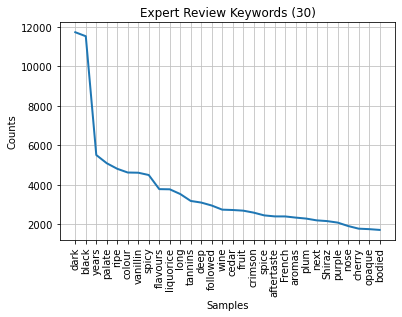

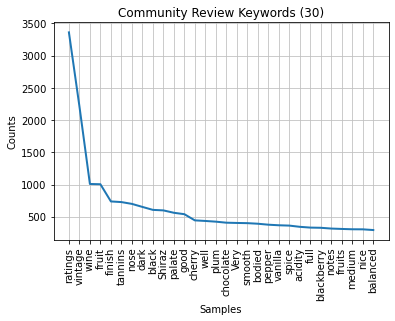

            Word  Frequency        Word  Frequency
0           dark      11722     ratings     3362.0
1          black      11520     vintage     2216.0
2          years       5513        wine     1009.0
3         palate       5096       fruit     1005.0
4           ripe       4815      finish      738.0
5         colour       4627     tannins      728.0
6       vanillin       4617        nose      700.0
7          spicy       4501        dark      653.0
8       flavours       3787       black      607.0
9      liquorice       3778      Shiraz      599.0
10          long       3539      palate      562.0
11       tannins       3189        good      540.0
12          deep       3107      cherry      444.0
13      followed       2958        well      435.0
14          wine       2749        plum      424.0
15         cedar       2731   chocolate      408.0
16         fruit       2698        Very      404.0
17       crimson       2598      smooth      401.0
18         spice       2459    

In [113]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import nltk
from nltk import FreqDist
import pandas as pd
import re
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
#nltk.download('stopwords')

wine_data = pd.read_csv("final_wine_data.csv", encoding="ISO-8859-1")
df = wine_data[['Expert_Description', 'desc_vivino', 'Wine', 'Vintage']]

EX_res = 'Expert_Description'
DV_res = 'desc_vivino'

EX_res = 'Expert_Description'
DV_res = 'desc_vivino'


def remove_unessentials(col):
    re_list = [r'[^a-zA-Z ]\s?', r'\b\w{1,3}\b']  # remove words with 3 characters and numbers etc
    regs = re.compile('|'.join(re_list))
    re_df = df[col].str.replace(regs, r'', regex=True)
    return re_df


# find fx, relevancy, types etc for resources

def word_fx_analysis(tokens):
    re_df2 = remove_unessentials(tokens)
    a = re_df2.str.cat(sep=' ')
    word_tokens = nltk.tokenize.word_tokenize(a)
    tokens_without_sw = [word for word in word_tokens if not word in stopwords.words()]
    word_freq = nltk.FreqDist(tokens_without_sw)
    return word_freq


word_freq_EX_res = word_fx_analysis(EX_res)
word_freq_DV_res = word_fx_analysis(DV_res)

EX_res_list = pd.DataFrame(word_freq_EX_res.most_common(), columns=['Word', 'Frequency'])
fd1 = nltk.FreqDist(word_freq_EX_res)
fd1.plot(30, cumulative=False, title='Expert Review Keywords (30)')

DV_res_list = pd.DataFrame(word_freq_DV_res.most_common(), columns=['Word', 'Frequency'])
fd2 = nltk.FreqDist(word_freq_DV_res)
fd2.plot(30, cumulative=False, title='Community Review Keywords (30)')

    
EX_res_df = pd.DataFrame(word_freq_EX_res.most_common(), columns=['Word', 'Frequency'])    
DV_res_df = pd.DataFrame(word_freq_DV_res.most_common(), columns=['Word', 'Frequency'])    
print(pd.concat([EX_res_df, DV_res_df], axis=1).head(50))
    
 

The above *'word'* and *'frequency'* output show the style of words used by wine experts and non experts. Words used by experts are strong and descriptive, for example, *'palate'*, *'dark'* and *'ripe'*. In contracts, frequently, non wine experts use words *'fruit'*, *'finish'* and *'good'*.